In [1]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from tqdm.auto import tqdm, trange
import matplotlib as mpl
from scipy.sparse import csr_matrix
import numba

sys.path.append('../Numerical_methods')
from bachelor_funcs import analytic_green
from matrix_calculator import A_matrix
from bachelor_funcs import color_use

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}
mpl.rc('font', **font)

$$\partial_t \Sigma = \frac{3}{r}\partial_r\left[r^{1/2}\partial_r(\Sigma r^{1/2})\right]$$
*Explicit timestepping*:
$$\Rightarrow \Sigma(t + \Delta t) = \Delta t\;\cdot\; \frac{3}{r}\partial_r\left[r^{1/2}\partial_r(\Sigma r^{1/2})\right]$$

# No defined boundary condtions

In [2]:
N = 1001
r_i = 0.01
r_f = 2.1
r = np.linspace(r_i, r_f, N)
Δr = r[1] - r[0]
print(Δr)

D1 = A_matrix(4, 1, N) / Δr
sD1 = csr_matrix(D1)


0.00209


In [3]:
def Σ_step(Σ, Δ_t):
    return Σ + Δ_t * (3 / r) * (sD1 @ (r**(1/2) * (sD1 @ (Σ * r**(1/2)))))

In [4]:
T_start = 0.006

T_step = np.array([0.008, 0.016, 0.032, 0.064, 0.128, 0.256])


Σ0 = analytic_green(r, T_start)
sol_nobound = []
Δt_solved = []
t_solved = []

Δt = 1e-6
t = T_start / 12
step = 0
ε_rel=1e-2
ε_abs=1e-2
while t <= T_step[-1] / 12:
    res = Σ_step(Σ0, Δt)
    δΣ = np.average(abs(res[Σ0 != 0] - Σ0[Σ0 != 0]) / Σ0[Σ0 != 0])
    ε_tol = ε_rel


    Δt_next =  0.95*(ε_tol/δΣ) * Δt
    if Δt_next > 1.2 * Δt:
        Δt_next = 1.2 * Δt
    if Δt_next < 0.8 * Δt:
        Δt_next = 0.8 * Δt 
    Δt = Δt_next

    if any(np.isnan(res)) == True:
        break

    if δΣ <= ε_tol:
        step += 1
        t += Δt
        sol_nobound.append(res)
        Σ0 = res
        Δt_solved.append(Δt)
        t_solved.append(t)

    

In [5]:
i_t = []
for τ in T_step:
    i_t.append(np.argmin(abs(τ - np.asarray(t_solved) * 12)))
i_t

[4940, 7302, 8478, 9369, 11093, 14588]

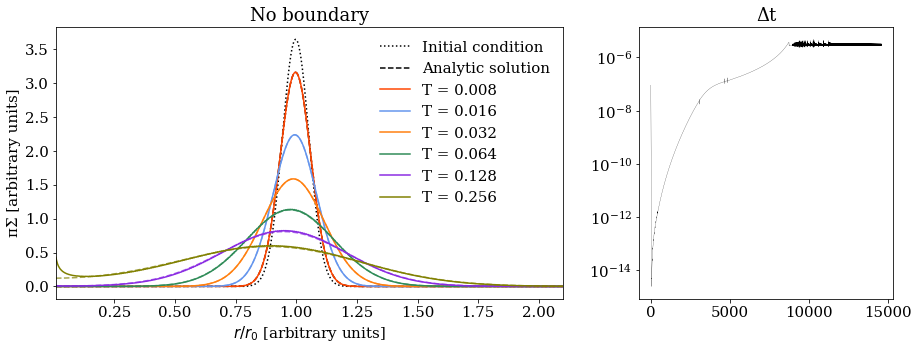

In [6]:
fig, axs = plt.subplots(1,2, figsize = (15, 5), gridspec_kw={'width_ratios': [2, 1]})

axs[0].plot(r, np.pi *analytic_green(r, T_start), c='black', ls=':', label = 'Initial condition')
axs[0].plot(r, np.pi *  analytic_green(r, 0.008), label='Analytic solution', c='black', ls='--')
axs[0].set(xlabel='$r/r_0$ [arbitrary units]', ylabel='πΣ [arbitrary units]', title = f'No boundary', xlim = (r_i, r_f))

for i, col in zip(i_t, color_use):
    axs[0].plot(r, np.pi * sol_nobound[i], label = f'T = {t_solved[i] * 12:1.3f}', c = col)
    axs[0].plot(r, np.pi * analytic_green(r, t_solved[i]*12), c = col, ls='--', alpha=0.7)
axs[0].legend(frameon = False)

axs[1].set(title = 'Δt')
axs[1].semilogy(Δt_solved, '-', lw=0.2, c = 'black')


# With boundary condtions $\partial_r(\Sigma r^{1/2})=0$

In [7]:
r_ghost = np.concatenate((np.array([r[0] - Δr]), r, np.array([r[-1] + Δr])))
r_ghost_plus = np.concatenate((np.array([r[0] - 2 * Δr]), r_ghost, np.array([r[-1] + 2*Δr])))

D1_g = A_matrix(6, 1, N + 4) / Δr
D1_g = A_matrix(6, 1, N + 4) / Δr
sD1_g = csr_matrix(D1_g)
(D1_g * Δr)[-3,-5:]

array([ 0.08333333, -0.66666667,  0.        ,  0.66666667, -0.08333333])

In [8]:
def Σ_step_ghost_old(Σ, Δ_t):
    inner = Σ * r**(1/2)
    ghost_i1 = np.array([inner[1]])
    ghost_i2 = np.array([inner[2]])
    ghost_f1 = np.array([inner[-2]])
    ghost_f2 = np.array([inner[-3]])

    inner_ghost = np.concatenate((ghost_i2, ghost_i1, inner, ghost_f1, ghost_f2))
    step = (3 / r_ghost_plus) * (sD1_g @ (r_ghost_plus**(1/2)  * (sD1_g @ inner_ghost)))
    return Σ + Δ_t * step[2 : -2]

In [9]:
def Σ_step_ghost_old2(Σ, Δ_t):
    inner = Σ * r**(1/2)

    inner[0] = 0
    inner[-1] = 0

    step = (3 / r) * (sD1 @ (r**(1/2)  * (sD1 @ inner)))
    return Σ + Δ_t * step

In [10]:
def Σ_step_ghost(Σ, Δ_t):
    inner = Σ * r**(1/2)

    df  = (np.roll(inner,-1) - np.roll(inner,1))/(2*Δr)
    df2 = (np.roll(inner,-1) + np.roll(inner,1) - 2*inner)/Δr**2

    dΣdt = 3/(r**1.5)*df + 3/r**0.5*df2

    dΣdt[0] = 9/2*Σ[0]/r[0]**2
    dΣdt[-1] = 9/2*Σ[-1]/r[-1]**2
    dΣdt[0] = 0.
    dΣdt[-1] = 0.

    return Σ + Δ_t * dΣdt

In [11]:
T_start = 0.006

T_step = np.array([0.008, 0.016, 0.032, 0.064, 0.128, 0.256])


Σ0 = analytic_green(r, T_start)
sol = []
Δt_used = []
t_solved = []
all_δΣ = []

Δt = 1e-5
t = T_start / 12
step = 0
ε_rel=1e-2
ε_abs=1e-4
while t <= T_step[-1] / 12:
    res = Σ_step_ghost_old2(Σ0, Δt)
    #δΣ = np.linalg.norm(res - Σ0) / np.linalg.norm(Σ0)
    δΣ = np.abs((res - Σ0) / (np.abs(Σ0) + ε_abs)).max()
    all_δΣ.append(δΣ)
    ε_tol = ε_rel

    if δΣ == 0:
        Δt_next = 2 * Δt
    else:
        Δt_next =  0.95*(ε_tol/δΣ) * Δt
        if Δt_next > 1.2 * Δt:
            Δt_next = 1.2 * Δt
        if Δt_next < 0.1 * Δt:
            Δt_next = 0.1 * Δt 
    

    if any(np.isnan(res)) == True:
        break

    if δΣ <= ε_tol:
        step += 1
        t += Δt
        sol.append(res)
        Σ0 = res
        t_solved.append(t)
    Δt = Δt_next
    Δt_used.append(Δt)

    if step == 1e6:
        break

In [12]:
i_t = []
for τ in T_step:

    i_t.append(np.argmin(abs(τ - np.asarray(t_solved) * 12)))
i_t

[187, 628, 1382, 2998, 6231, 12687]

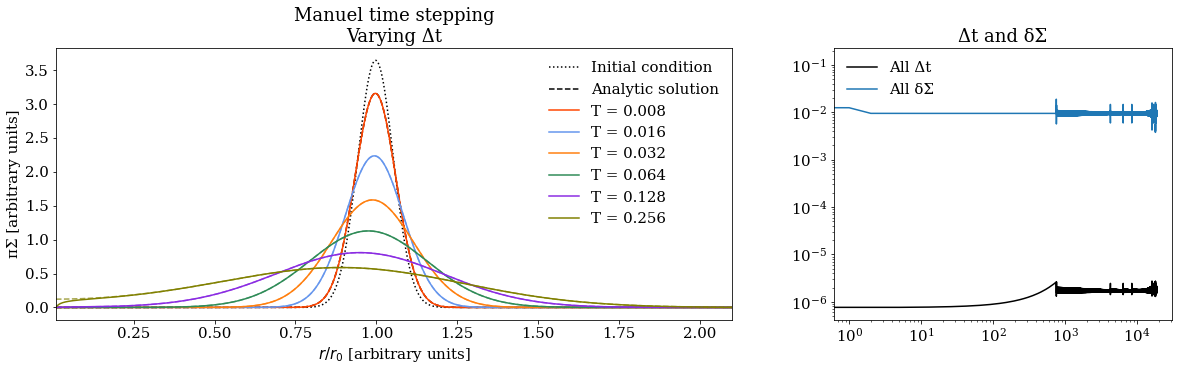

In [13]:
fig, axs = plt.subplots(1,2, figsize = (20, 5), gridspec_kw={'width_ratios': [2, 1]})

axs[0].plot(r, np.pi *analytic_green(r, T_start), c='black', ls=':', label = 'Initial condition')
axs[0].plot(r, np.pi *  analytic_green(r, 0.008), label='Analytic solution', c='black', ls='--')
axs[0].set(xlabel='$r/r_0$ [arbitrary units]', ylabel='πΣ [arbitrary units]', title = f'Manuel time stepping\nVarying Δt', xlim = (r_i, r_f))

for i, col in zip(i_t, color_use):
    axs[0].plot(r, np.pi * sol[i], label = f'T = {t_solved[i] * 12:1.3f}', c = col)
    axs[0].plot(r, np.pi * analytic_green(r, t_solved[i]*12), c = col, ls='--', alpha=0.7)
axs[0].legend(frameon = False)

axs[1].set(title = 'Δt and δΣ')
axs[1].loglog(Δt_used, '-', c = 'black', label = 'All Δt')

axs[1].loglog(all_δΣ, label = 'All δΣ')
axs[1].legend(frameon = False)
